In [1]:
!pip install dfply
import pandas as pd
import numpy as np
import math
from dfply import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statistics 
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import pearsonr
import plotly.graph_objects as go
import warnings
from scipy.stats import shapiro
from datetime import date, timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
players = pd.read_pickle('/content/drive/My Drive/Capstone/Data/Clean/Players_Clean.pkl')
players = players[players.sofifa_id.notnull()]
players.sofifa_id = players.sofifa_id.astype("int") 

In [0]:
markval = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/markval_detailed.pkl")

In [0]:
stats_wide = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/player_stats_wide.pkl")

In [0]:
def_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/defenders_Clean.pkl")

In [0]:
fb_sofifa = pd.read_pickle("/content/drive/My Drive/Capstone/Data/Clean/by_position_sofifa/full_backs_Clean.pkl")

In [0]:
def merge_all(df_sofifa, players, markval, stats):
  merged_sofifa = pd.merge(df_sofifa, players[["tm_id","sofifa_id"]])
  merged_sofifa = pd.merge(merged_sofifa, markval, on = ["tm_id","year"])
  no_mv_cols = (merged_sofifa.select_dtypes(include=['float64']) >> select(~X.mv)).columns.tolist()
  no_mv_cols.insert(0, "mv")
  df_sofifa_floats = merged_sofifa[no_mv_cols]
  df_sofifa_stats = pd.merge(merged_sofifa, stats, on = ["tm_id","year"])
  sofifa_cols = df_sofifa.select_dtypes("float64").columns.tolist()
  sofifa_cols.insert(0, "mv")
  return merged_sofifa,df_sofifa_floats,df_sofifa_stats,sofifa_cols

In [0]:
def pair_plot(df,h = 900,w = 900):
  col_name = lambda x : x.split("_")[0][0:2] + "_" + x.split("_")[1][0:2] if len(x.split("_")) > 1 else x
  fig = px.scatter_matrix(df,labels=
                        {col: col_name(col) for col in df.columns},
                        height = h, width = w
                        )
  fig.update_traces(diagonal_visible=False)
  fig.show()
  col_abbrs = {
      "column_abbr" : list(map(col_name, df.columns)),
      "column_name" : df.columns
  }
  return fig, pd.DataFrame(col_abbrs)

In [0]:
def heat_map(df, diagonal = "upper", w = 30,h = 20):
  df = df.select_dtypes(include=['float64'])
  corr = df.corr()
  plt.figure(figsize = (w, h))
  if(diagonal == "lower"):
    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  elif(diagonal == "upper"):
    mask = np.tril(np.ones_like(corr, dtype=np.bool))
    ax = sns.heatmap(corr, annot = True, linewidths=.5, mask = mask)
  else:
    ax = sns.heatmap(corr, annot = True, linewidths=.5)
  ax.tick_params(right=True, top=True, labelright=True, labeltop=True)
  plt.show()
  return plt

In [0]:
def get_columns(df,cumulative):
  if(cumulative):
    cols = (df >> select(starts_with('cum'))).columns.tolist()
  else:
    cols = (df >> select(~starts_with('cum'))).columns.tolist()
  return cols

In [0]:
cb_sofifa, cb_sofifa_floats, cb_sofifa_stats, cb_sofifa_cols = merge_all(def_sofifa, players,markval,stats_wide)
fb_sofifa, fb_sofifa_floats, fb_sofifa_stats, fb_sofifa_cols = merge_all(fb_sofifa, players,markval,stats_wide)

In [0]:
cb_sofifa_stats = cb_sofifa_stats >> select(~X.g, ~X.a,~X.mpg, ~X.cum_g, ~X.cum_a, ~X.cum_mpg)
fb_sofifa_stats = fb_sofifa_stats>> select(~X.g,~X.cum_g, ~X.mpg, ~X.cum_mpg)

# Defenders' attributes in fifa correlation to market value and real life statistics

In [38]:
cb_pp,col_abbrs = pair_plot(cb_sofifa[cb_sofifa_cols])

As we can see, most of the in game attributes for the central deffenders are correlated to each other. The correlation of the attributes with the market value of the player is also similar for all of the attributes.

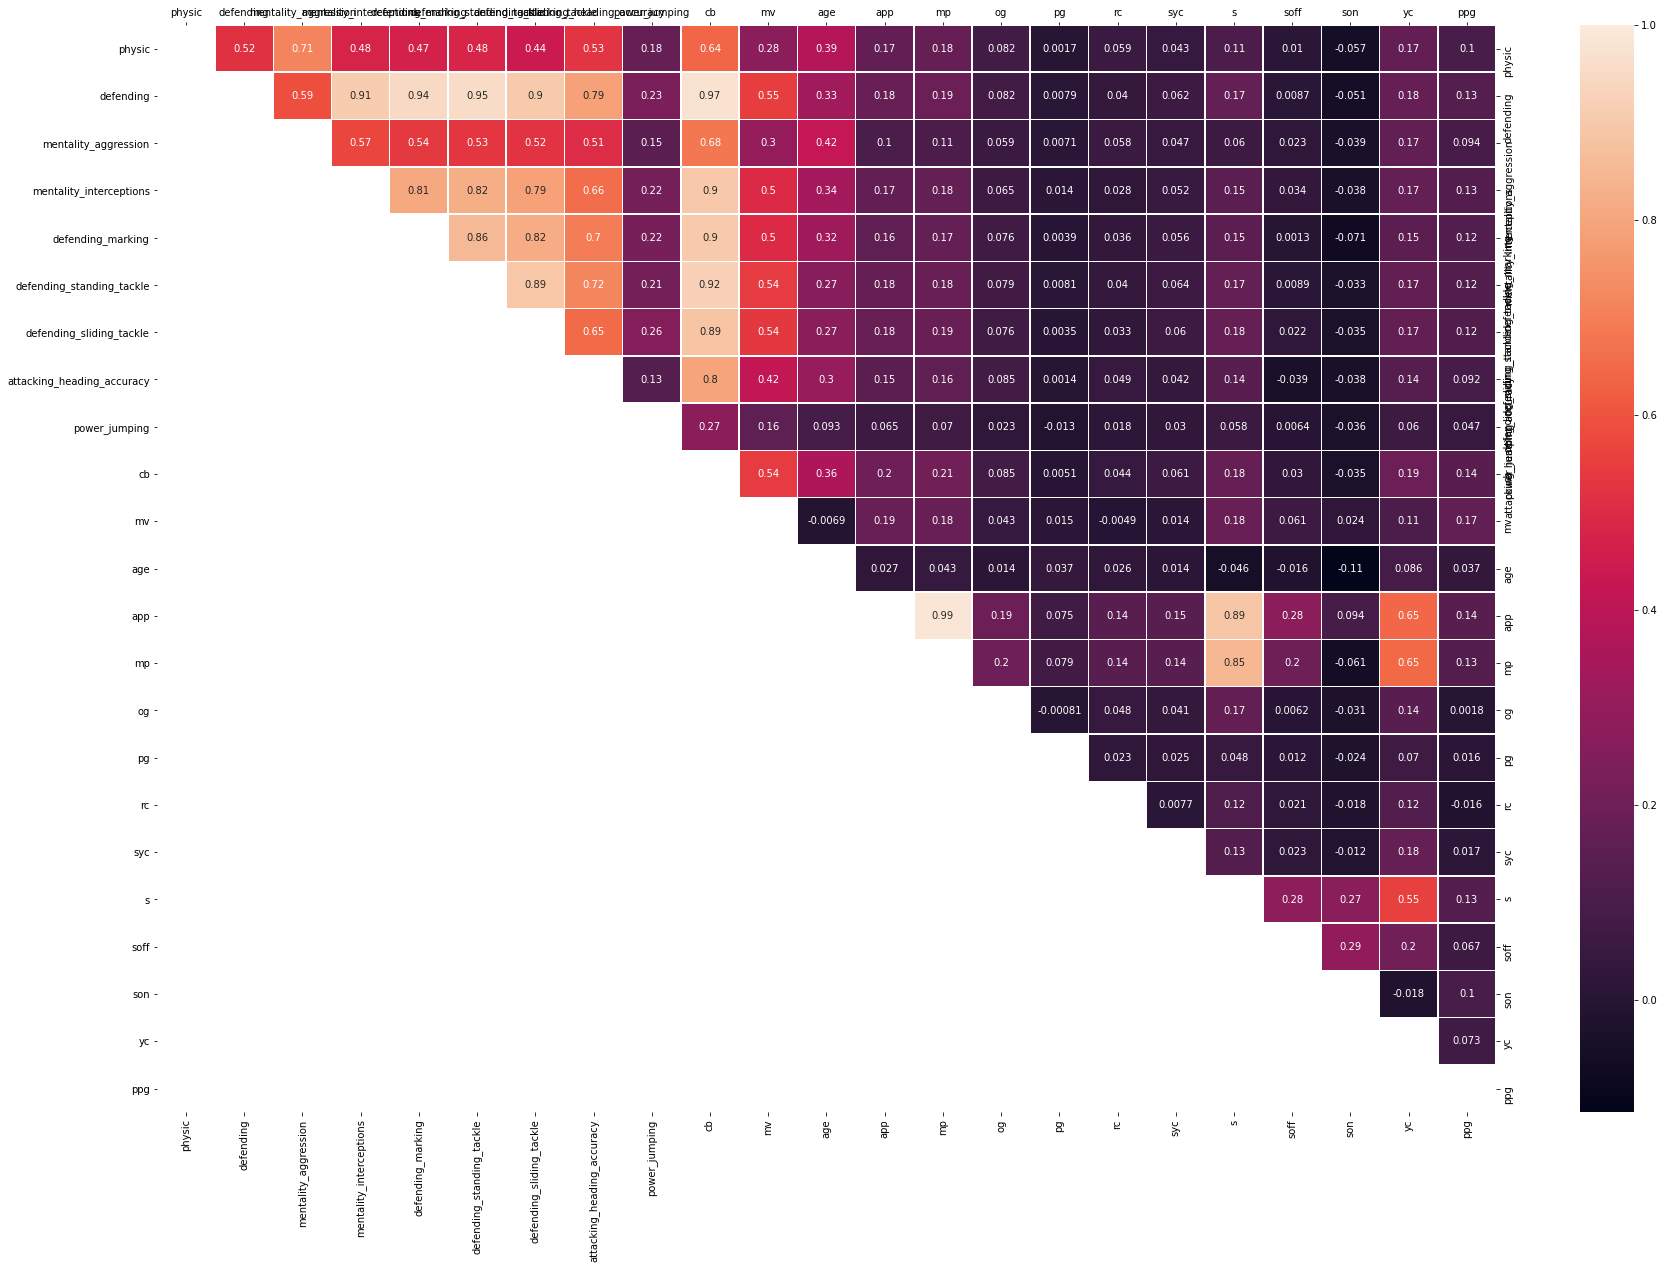

In [56]:
non_cum = get_columns(cb_sofifa_stats, cumulative = False)
df_hm = heat_map(cb_sofifa_stats[non_cum] >> select(~X.rcb, ~X.lcb),"upper")

As we can see in general the in game attributes are not correlated to the real life stats, looks like the number of yellow cards is the most correlated out of the real stats, as the defenders are likely to get many yellow cards.

As we can see defending skill of the player has the highest correlation with his market value and power jumping the lowest. Player's tackling and intercaption skills are also correlated, while physic and heading accuracy are not correlated to the mv.

In [19]:
fb_pp,col_abbrs = pair_plot(fb_sofifa[fb_sofifa_cols])

The attributes in sofifa look a little bit more correlated to market value for full backs.

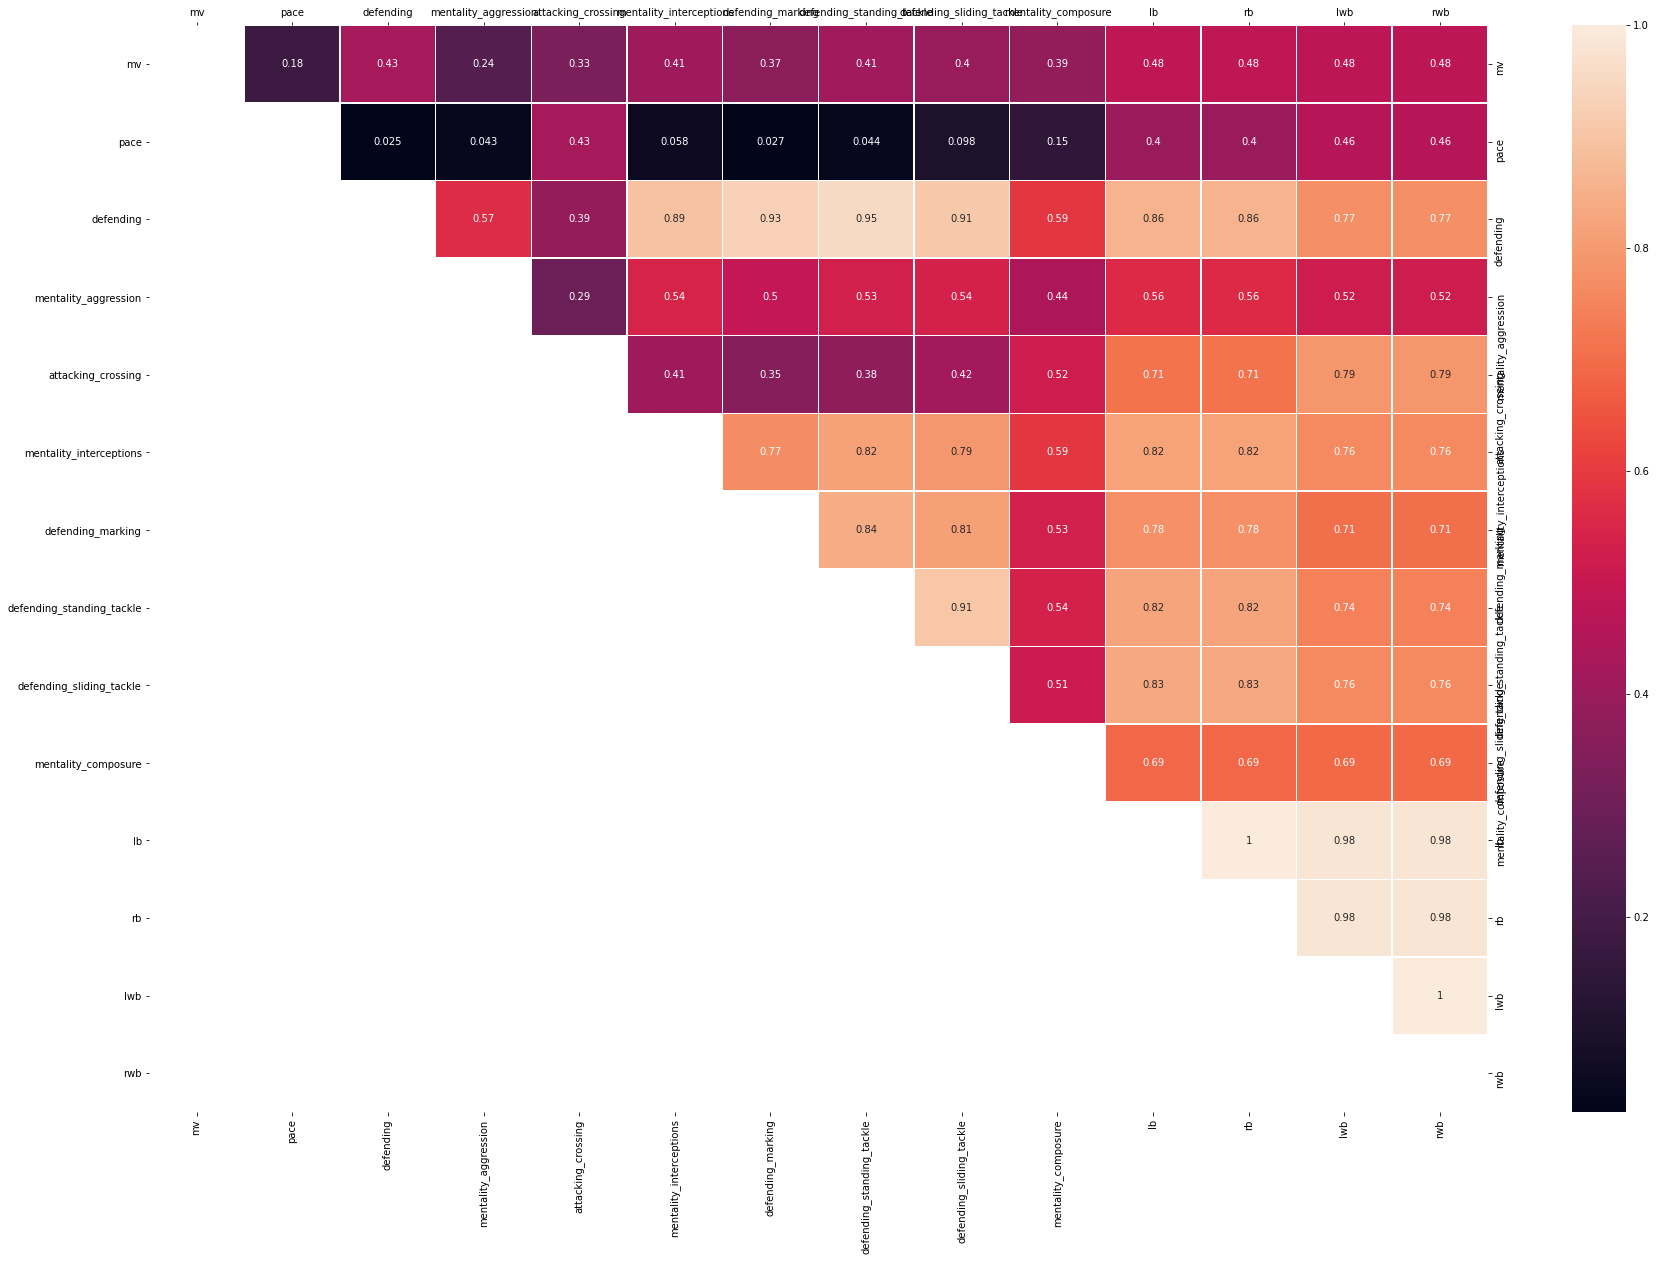

In [66]:
fb_hm = heat_map(fb_sofifa_stats[fb_sofifa_cols], "upper")

For full backs the most correlated variables to market value are defending and intercaption skills.

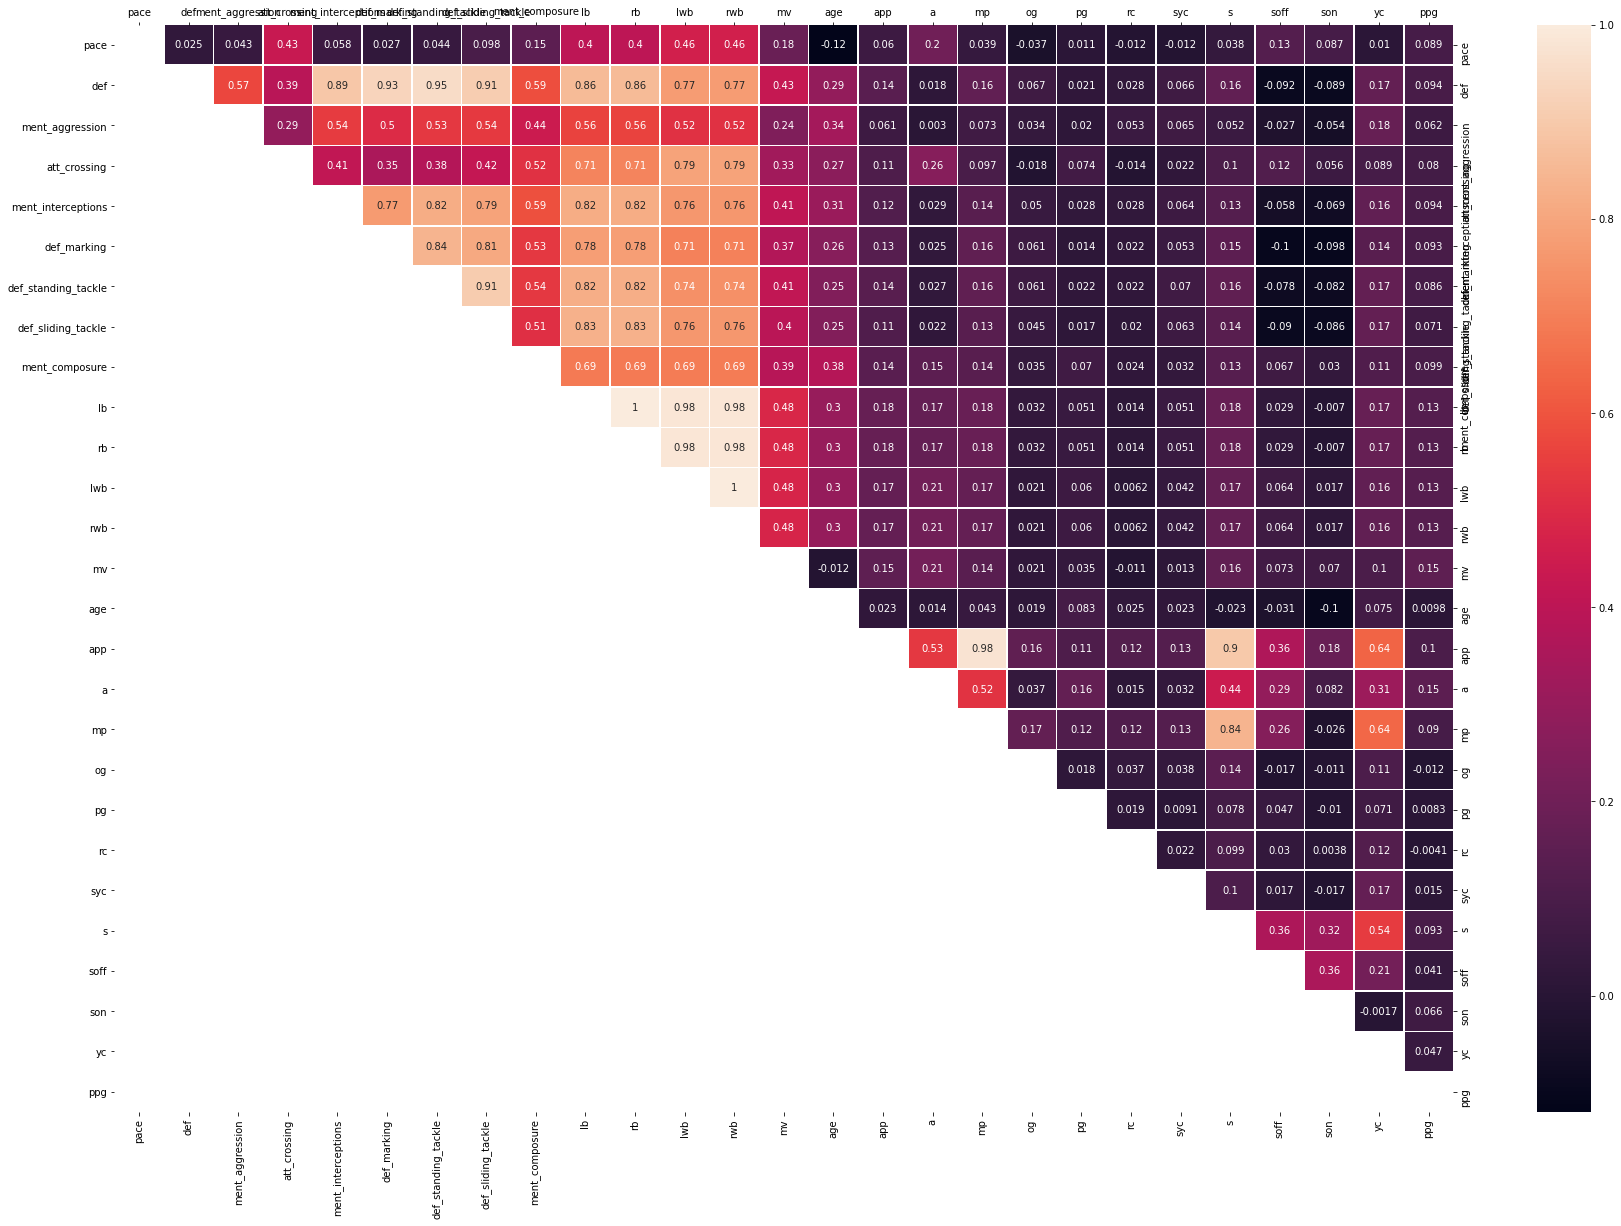

In [71]:
cols = fb_sofifa_stats.columns
cols = [col.replace("defending","def") for col in cols ]
cols = [col.replace("attacking","att") for col in cols ]
cols = [col.replace("mentality","ment") for col in cols ]
fb_sofifa_stats.columns = cols
non_cum = get_columns(fb_sofifa_stats, cumulative = False)
df_hm = heat_map(fb_sofifa_stats[non_cum],"upper")

We can see that the only real life statistics that are somehow correlated to each other are player's assists and pace and crossing skills.